# Capítulo 2: Modulaciones de orden superior 
## Esquemas de modulación digital PSK y QAM

## Concepto importante previo 
### Modulación en cuadratura 
La modulación en cuadratura se basa en la siguiente ecuación 

$$Acos(wt + \theta) = I(t)cos(wt) - Q(t)sin(wt)$$
Donde 

$I(t)$ es la señal en fase 

$Q(t)$ es la señal en cuadratura 

$A$ es igual a $A = \sqrt{I^2(t) + Q^2(t)}$ 

$\theta = tan^{-1}(\frac{Q(t)}{I(t)})$

Las señales $I(t)$ y $Q(t)$ son generada apartir del mensaje $m(t)$. La transformación de $m(t)$ a  $I(t)$ y $Q(t)$ debe cumplir la asignación de los puntos en el espacio I y Q segun sea PSK o QAM

### **PSK (Phase-Shift Keying Modulation)** 
Las señales se diferencian entre si por la fase, por ende todas las señales tienen la misma amplitud pero diferente fase. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import komm

np.random.seed(40)

In [2]:
fs = 10000 # Frecuencia de muestreo "general"
r = 1 #radio de la circunferencia 
t = np.arange(-1,1,1/fs)
y_c = np.sqrt(r**2 - t**2)

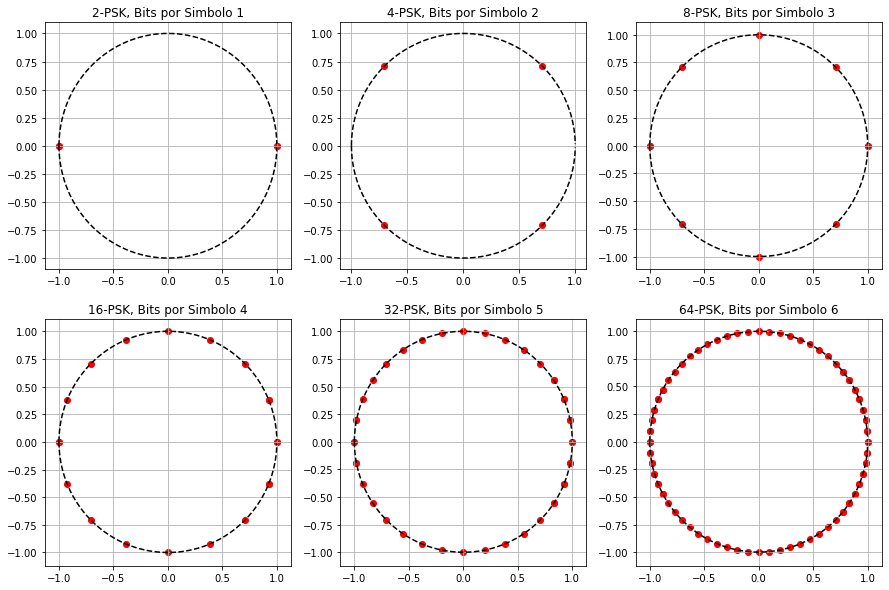

In [3]:
puntos = [2,4,8,16,32,64]
plt.figure(figsize=(15,10))
for k,j in enumerate(puntos):
    if j == 2: 
        i = 0
    else:
        i = 360/j-45 
    theta = np.arange(i,(360/j + 1)*j/2,360/j)
    x = np.cos(theta*np.pi/180)
    y = np.sin(theta*np.pi/180)
    plt.subplot(2,3,k+1)
    
    plt.scatter(x,y,color='r')
    plt.scatter(x,-1*y,color='r')
    plt.plot(t,y_c,'k--',t,-1*y_c, 'k--')
    plt.title("{}-PSK, Bits por Simbolo {}".format(j,int(np.log2(j))))
    plt.grid()

ejemplo de modulación con PSK

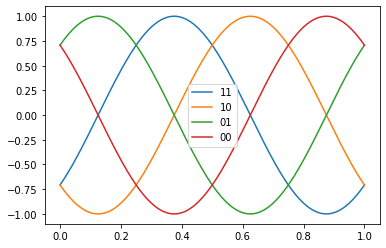

In [4]:
PSK_4 = komm.PSKModulation(4,phase_offset=np.pi/4)
bits = np.array([1,1,1,0,0,1,0,0])
PSK_4.channel_snr = 0.001
A = PSK_4.modulate(bits)
t = np.arange(0,1,1/fs)
x = np.cos(2*np.pi*t*1)
y = np.sin(2*np.pi*t*1)

for i in A:
    plt.plot(t,i.real*x-i.imag*y)
plt.legend(["11","10","01","00"])

ejemplo con SNR 

In [5]:
bits = np.random.randint(0,2,1000) 
PSK_4 = komm.PSKModulation(4,phase_offset=np.pi/4)  
simbols = PSK_4.modulate(bits)
canal = komm.AWGNChannel(50)
simbols_r = canal(simbols)
etiquetas = PSK_4.bits_to_symbols(bits)

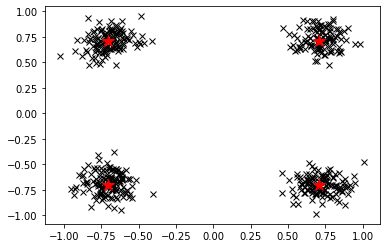

In [6]:
for i in range(PSK_4.order):
    plt.plot(simbols_r[etiquetas == i].real,simbols_r[etiquetas == i].imag,'xk')
plt.plot(PSK_4.constellation.real,PSK_4.constellation.imag, 'r*',markersize=12)

ejemplo secuencia de bits modulada con 4-PSK en el tiempo

In [7]:
def x_(simbols,tB,fc=1):
    t_c = np.arange(0,tB,1/fs)
    
    tf = tB*len(simbols)
    t = np.arange(0,tf,1/fs)
    
    x = np.cos(2*np.pi*t_c*fc)
    y = np.sin(2*np.pi*t_c*fc)
    
    fm = np.array([])

    for i in simbols:
        fm = np.append(fm, i.real*x-i.imag*y) 
    return t,fm

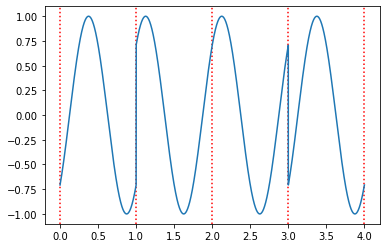

In [8]:
bits = np.random.randint(0,2,8) 
simbols = PSK_4.modulate(bits)
t,x_t = x_(simbols,1)
for i in range(len(simbols)+1):
    plt.axvline(i, color='r', ls="dotted")
plt.plot(t,x_t)

Como se puede ver en la anteriro gráfica hay problemas con la continuidad de la señal con lo que trae el porblema de fuga de frecuencias y no permitiría recuperar, para ello como se vio en el capítulo uno se utiliza el filtro del coseno realzado 

In [9]:
def raisedCosinePulse(roll_off,span):
    t = np.arange(-4*span,4*span,1/fs)
    a = np.cos(np.pi*roll_off*t/span)/(1-(4*roll_off**2*t**2)/span**2)
    h = np.sinc(t/span)*a
    return h 

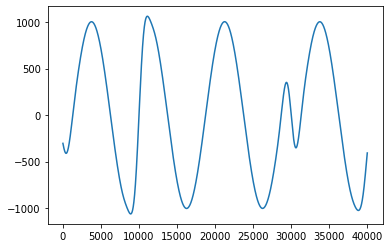

In [10]:
fc = 1
span = 0.1
roll_off = 0.5

t,x_t = x_(simbols,1,fc = fc)

h = raisedCosinePulse(roll_off,span)*np.cos(2*np.pi*np.arange(-4*span,4*span,1/fs)*fc)

x_send =  np.convolve(x_t,h,mode="same")

plt.plot(np.arange(len(x_send)),x_send)

### Impacto en el espectro de frecuencia 
Como se dijo anteriormente las discontinuidades que se generan en la modulación lo que probocan es la aparición de otras frecuencias que producen mas consumo de banda, en el siguiente ejemplo se muestra esta situación y como el RCC nos ayuda a solventarlo 

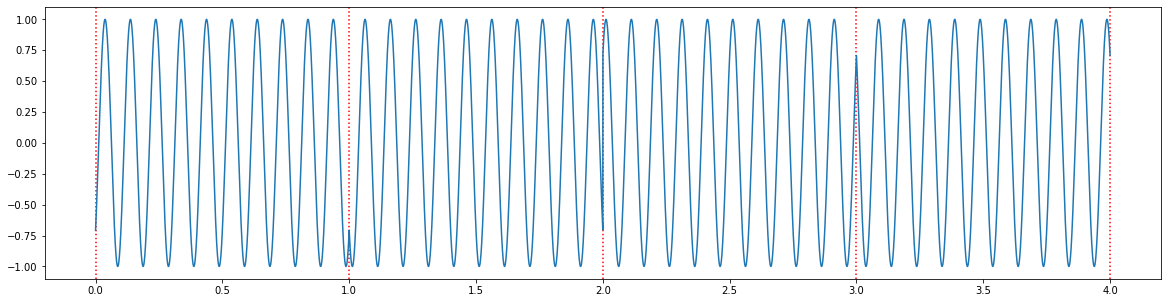

In [11]:
bits = np.array([1,1,1,0,0,1,0,0])
simbols = PSK_4.modulate(bits)
t,x_t = x_(simbols,1,fc=10)

plt.figure(figsize=(20,5))
for i in range(len(simbols)+1):
    plt.axvline(i, color='r', ls="dotted")
plt.plot(t,x_t)

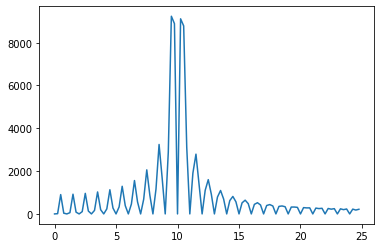

In [12]:
F = np.fft.fft(x_t) 
f_ = np.fft.fftfreq(len(F),1/fs)
plt.plot(f_[range(100)],abs(F[range(100)]))

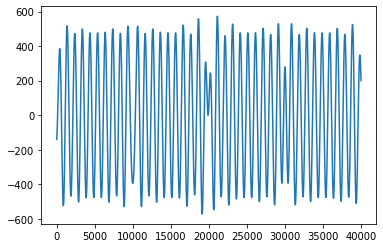

In [13]:
fc = 10
span = 0.1
roll_off = 0

h = raisedCosinePulse(roll_off,span)*np.cos(2*np.pi*np.arange(-4*span,4*span,1/fs)*fc)

x_send =  np.convolve(x_t,h,mode="same")

plt.plot(np.arange(len(x_send)),x_send)

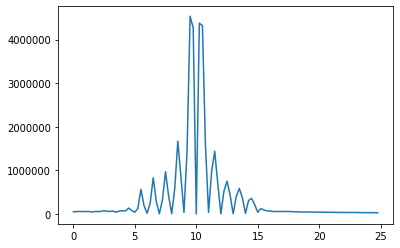

In [14]:
F = np.fft.fft(x_send) 
f_ = np.fft.fftfreq(len(F),1/fs)
plt.plot(f_[range(100)],abs(F[range(100)]))

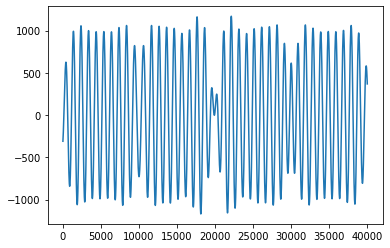

In [15]:
fc = 10
span = 0.2
roll_off = 0

h = raisedCosinePulse(roll_off,span)*np.cos(2*np.pi*np.arange(-4*span,4*span,1/fs)*fc)

x_send =  np.convolve(x_t,h,mode="same")

plt.plot(np.arange(len(x_send)),x_send)

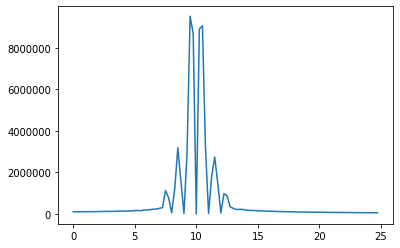

In [16]:
F = np.fft.fft(x_send) 
f_ = np.fft.fftfreq(len(F),1/fs)
plt.plot(f_[range(100)],abs(F[range(100)]))

## Evaluación 

### Definiciones 
* **Baudio**: Es la es una medida de velocidad que nos dice la cuantos simbolos o señales se generan en un segundo. Hay que tener cuidado de no confunfirlo con la tasa de bits o bits rate, ya que cada simbolo puede representar diferentes contidades de simbolos.

Tasa de bits = $\frac{1}{T_b}$ donde $T_b$ es igual a la diración de un bits 

Baudios = $\frac{1}{T_s}$ donde $T_s$ es igual a la duración del simbolo 
![](./images/baudio.jpg)

* **Modulador en Cuadratura**: El modulador en cuadratura es un modulador que se basa en la identidad trigonometica para modular la fase y la amplitud de una portadora solo variando la amplitud de dos señales que se suman para dar como resultado la portadora. Cabe resaltar que las dos señales que se suman deben ser ortogonales para que cada una represente información diferente 


$$Acos(wt + \theta) = I(t)cos(wt) - Q(t)sin(wt)$$
Donde 

$I(t)$ es la señal en fase 

$Q(t)$ es la señal en cuadratura 

$A$ es igual a $A = \sqrt{I^2(t) + Q^2(t)}$ 

$\theta = tan^{-1}(\frac{Q(t)}{I(t)})$

Las señales $I(t)$ y $Q(t)$ son generada apartir del mensaje $m(t)$. La transformación de $m(t)$ a  $I(t)$ y $Q(t)$ debe cumplir la asignación de los puntos en el espacio I y Q segun sea PSK o QAM

![](./images/cuadratura.png)



* **Proceso de mapeo (mapping)** EL proceso de mapeo es llevar los bits del mensaje a el espacio de las amplitudes que se ven en la constelaciones, básicamente el mapeo es tomar el conjunto de bits que se puede representar con cada simbolo y apartir de ellos encontrar los valores de $I$ y $Q$, las siguientes imagenes ilustran esto con 8-psk y 16-qam, donde se ve que cada conjunto de bits le pertenece un punto en la gráfica de constelaciones 


<table><tr>
<td> <img src="./images/8-psk.png" alt="Drawing" title="adam solomon's hello" style="width: 250px;"/> </td>
<td> <img src="./images/16-qam.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

* **Ruido aditivo blanco Gaussiano (AWGN: Additive White Gaussian Noise)** 
El rudio es todo aquello que no es de nuestro interes y que está presente, blanco en este contesto se refiere a no que no hay correlación entre sus valores y Gassiano significa que los valores siguen una distribución de probabilidades gausiana. En comunicación este ruido generado por fuentes de radiación electromagnetica nos ayuda a modelar el canal por el cual enviamos nuestros datos 

Text(0.5, 1.0, 'Autocorrelación')

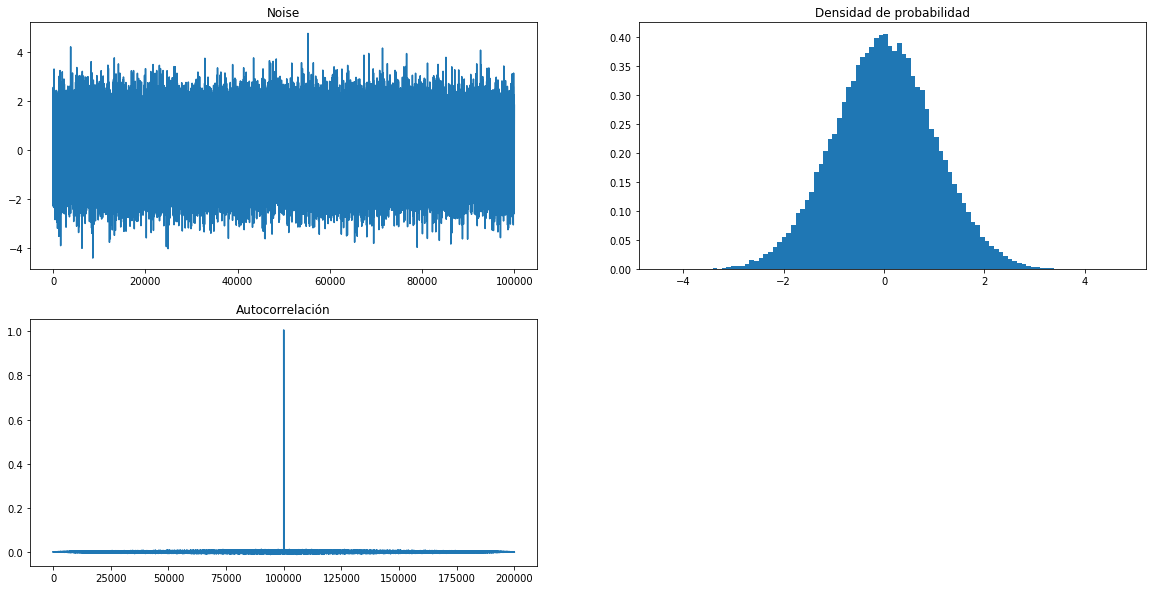

In [17]:
import scipy.stats as stats

Noise = stats.norm.rvs(size=100000, loc=0, scale=1)
corr = 1/len(Noise) * np.correlate(Noise, Noise, mode='full')

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(Noise)
plt.title('Noise')
plt.subplot(2,2,2)
plt.hist(Noise, 100, density=True)
plt.title('Densidad de probabilidad')
plt.subplot(2,2,3)
plt.plot(corr)
plt.title('Autocorrelación')

## Simulaciones 
* El impacto en el espectro potencia de la variación del “Span” del filtro RRC en las señales PSK
Recordemos que el parámtro "Span" lo que hace con el RCC es aumentar o disminuir su permanecia en el tiempo de forma proporcional, en frecuencia pasa lo mismo pero de forma inversa, entonces si aumentamos la permanencia en el tiempo lo que estamos haciendo es que en frecuencia "dure menos" o limite más la banda, lo que ayuda a optimizar el espectro eliminando esa frecuencias generadas por las discontinuidades  

* El mínimo valor de SNR que permite la diferenciación visual de los símbolos de una señal 16-PSK (M = 16)

In [18]:
bits = np.random.randint(0,2,10000) 
PSK_16 = komm.PSKModulation(16,phase_offset=np.pi/4)  
simbols = PSK_16.modulate(bits)
canal = komm.AWGNChannel(110)
simbols_r = canal(simbols)
etiquetas = PSK_16.bits_to_symbols(bits)

Text(0.5, 1.0, '16-PSK SNR 110.0')

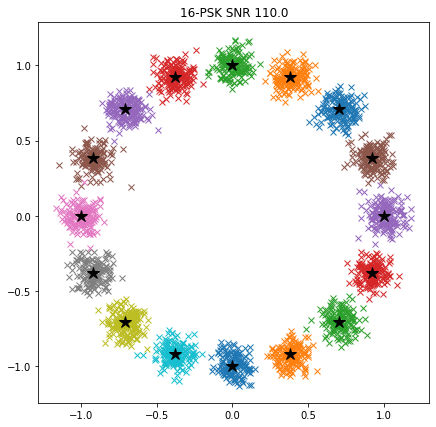

In [19]:
plt.figure(figsize=(7,7))
for i in range(PSK_16.order):
    plt.plot(simbols_r[etiquetas == i].real,simbols_r[etiquetas == i].imag,'x')
plt.plot(PSK_16.constellation.real,PSK_16.constellation.imag, 'k*',markersize=12)
plt.title("16-PSK SNR {}".format(canal.snr))